/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 100)                 │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

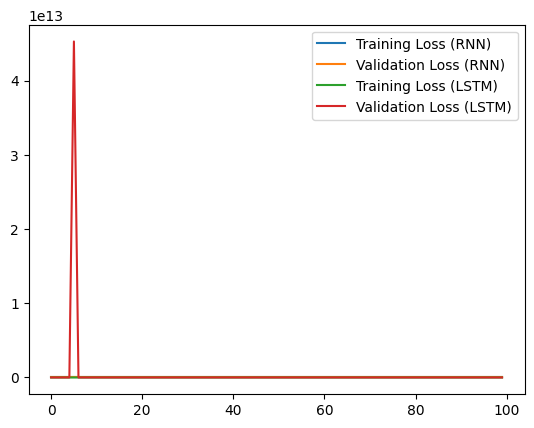

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
RNN Accuracy: 0.947
LSTM Accuracy: 0.584


In [5]:
# 정보전송을위해 사용하는변조방식 2가지 M-PSK,
# 1bit BPSK에서 복소수 평면 a+bj에서 0을보내고싶으면 -1을 보냄 , 1을보내고싶으면 1
# 2bit QPSK에서 복소수 평면 a+bj에서 00 = -1+j  /  10 = 1+j  /  11 = 1-j  /  01 = -1-j
# 3bit 8PSK에서 복소수 평면 a+bj에서 0 , 루트2 , 1
# 4bit 16QAM에서
# 6bit 64QAM
# 8bit 256QAM

#비트를 주고받을 때 조건 1개가있음 , 주고받는 데이터가 복소수임.
# 그 데이터를 보낼때 어떤 변조방식으로 보낸건지도 같이 보내줘야함. (왜냐면, BPSK 1bit보낸건지 16QAM 4bit 보낸건지 수신단에서는 모르기때문임)
# 복소수 보낼때 통신환경에 의해 노이즈가 무조건 껴서 1+ j 보내도 0.8+0.2j 이런식으로 들어옴 -> 그래서 어떤 변조방식을 사용했는지 같이 다 알려줘야하는거임
# 교수님 연구하고있는건 도감청할때 핫한 (군사연구) 북한이 어떤 신호를 쏠때 국정원에서 엿듣고싶을때 변조방식을 추측해서 들을 수 있게끔

# 이 변조방식을 모르고 받을때 이 변조방식을 구분해주는 모델을 만드는게 이번 프로젝트의 핵심임

#in-phase 실수 ,  Label이 변조방식중 1개를의미하는 숫자들임 (0이면 1bit , 1이면 2bit)
# 숫자 더러운이유는 임의적으로 노이즈 넣어서 그럼

#train데이터 test데이터 따로 줄거임
# 조건: 모델은 아무거나 써도되는데 이번학기에 배운걸로만 사용하기 / DNN CNN LSTM 이런것만 /

#평가 방법: 발표 할거임 - 예측정확도 40 / 학습속도 20 / 발표 40
#일정 코드 제출 12/1까지    -     발표 12/3 (다음주 수업 없음)



import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras


# data
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv')


# Data preprocessing
X = data.values[:,:-1] # 마지막  컬럼  전까지는  X로
Y = data.values[:,-1] # 마지막  컬럼은  Y로

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.2,random_state=7, stratify=Y)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # test set에는  transform만  사용하기

# dimension change: (3998,140) -> (3998,140,1)
train_x = tf.reshape(train_x,(train_x.shape[0],train_x.shape[1],1))
test_x = tf.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))







### model1 ###
# RNN / 레이어1개
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=100, input_shape = (train_x.shape[1],train_x.shape[2]), activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])  #binary_crossentropy (0과1만 필요해서 이걸로 loss 펑션 정의해야함) 이진 분류 문제에 적합한 손실 함수
hist = model.fit(train_x, train_y, epochs=100, batch_size=128, validation_data=(train_x, train_y), verbose=0) #epoch 많이해야함
### model1 ###



### model2 ###
#LSTM
model2 = keras.Sequential()
model2.add(keras.layers.LSTM(units=100, input_shape = (train_x.shape[1],train_x.shape[2]), activation='relu')) #LSTM은 simpleRNN만 바꾸면됨
model2.add(keras.layers.Dense(1,activation='sigmoid')) #안에 들어간 내용 다 똑같음
model2.summary()
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
hist2 = model2.fit(train_x, train_y, epochs=100, batch_size=128, validation_data=(train_x, train_y), verbose=0)
### model2 ###





# plot
plt.plot(hist.history["loss"], label="Training Loss (RNN)") #loss: 훈련 데이터에 대한 예측 오차
plt.plot(hist.history["val_loss"], label="Validation Loss (RNN)")  #val_loss: 검증 데이터에 대한 예측 오차
plt.plot(hist2.history["loss"], label="Training Loss (LSTM)")
plt.plot(hist2.history["val_loss"], label="Validation Loss (LSTM)")
plt.legend()
plt.show()




#Prediction
pred_rnn = model.predict(test_x) #입력 데이터에 대해 모델의 출력을 계산
pred_rnn = (pred_rnn >= 0.5) #예측 값이 0.5 이상이면 True (1), 0.5 미만이면 False (0)으로 변환
pred_lstm = model2.predict(test_x)
pred_lstm = (pred_lstm >= 0.5)

from sklearn.metrics import accuracy_score

accuracy_test_rnn= accuracy_score(test_y, pred_rnn)
print(f'RNN Accuracy: {accuracy_test_rnn}')

accuracy_test_lstm= accuracy_score(test_y, pred_lstm)
print(f'LSTM Accuracy: {accuracy_test_lstm}')